# create figures for med4 DE long term 

In [1]:
library(DESeq2)
library(RColorBrewer)
library(reshape2)
library("gplots")
library("GGally")                      # Load GGally package
library(goseq)
library(readxl)
library(tidyverse)
library("pheatmap")
library(corrplot)
library(circlize)

Warning message:
"package 'DESeq2' was built under R version 4.2.2"
Loading required package: S4Vectors

Warning message:
"package 'S4Vectors' was built under R version 4.2.2"
Loading required package: stats4

Loading required package: BiocGenerics

Warning message:
"package 'BiocGenerics' was built under R version 4.2.1"

Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: 'S4Vectors'


The following objects are masked from 'package:base':

    exp

In [4]:
library(ggrastr)

Warning message:
"package 'ggrastr' was built under R version 4.2.3"


In [5]:
library(ggrepel)

Warning message:
"package 'ggrepel' was built under R version 4.2.1"


In [6]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 300)

In [7]:
source('../src/common_functions.R')

Warning message:
"package 'ComplexHeatmap' was built under R version 4.2.1"
Loading required package: grid

ComplexHeatmap version 2.14.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))
! pheatmap() has been masked by ComplexHeatmap::pheatmap(). Most of the arguments
   in the original pheatmap() are identically supported in the new function. You 
   can still use the original fu

In [8]:
df_all_orig = read_csv(file.path('DE_results', 'MED4_all_FC_results.csv'))



Warning message:
"One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 53457 Columns: 34
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (22): contrast, protein_id, Assay, contrast1, Name, gene, locus_tag, old...
dbl  (7): logFC, AveExpr, pvalue, padj, start, end, gene_length
lgl  (5): Note, exception, down, up, is_de

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [9]:
df_all_orig

contrast,protein_id,logFC,AveExpr,pvalue,padj,Assay,contrast1,Name,gene,⋯,path,ecpath,Category,Membrane.transport,kegg_gene1,kegg_gene2,gene_id,down,up,is_de
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>
C2 - C1,WP_011132009.1,2.6029332,0.91671556,5.951467e-07,0.0004868287,Proteome,C2vsC1_prot,TX50_RS01980,NA,⋯,00910 Nitrogen metabolism [PATH:ko00910];02000 Transporters [BR:ko02000];02010 ABC transporters [PATH:ko02010],"K15578 nrtC, nasD; nitrate/nitrite transport system ATP-binding protein [EC:7.3.2.4]",Nitrogen metabolism,Membrane transport,nan,nan,TX50_RS01980,FALSE,TRUE,TRUE
C2 - C1,WP_011132596.1,1.7956460,2.04648813,8.763244e-07,0.0004868287,Proteome,C2vsC1_prot,ureC,ureC,⋯,00220 Arginine biosynthesis [PATH:ko00220];00230 Purine metabolism [PATH:ko00230];00791 Atrazine degradation [PATH:ko00791],K01428 ureC; urease subunit alpha [EC:3.5.1.5],AA/Nucleotide,NA,ureC,(ureC),TX50_RS05125,FALSE,TRUE,TRUE
C2 - C1,WP_011133327.1,1.1167539,1.46785946,1.025622e-06,0.0004868287,Proteome,C2vsC1_prot,acnB,acnB,⋯,00020 Citrate cycle (TCA cycle) [PATH:ko00020];00630 Glyoxylate and dicarboxylate metabolism [PATH:ko00630];00640 Propanoate metabolism [PATH:ko00640];00720 Carbon fixation pathways in prokaryotes [PATH:ko00720],K01682 acnB; aconitate hydratase 2 / 2-methylisocitrate dehydratase [EC:4.2.1.3 4.2.1.99],Photosynthesis/Carbon fixation,NA,acnB,(acnB),TX50_RS09075,FALSE,TRUE,TRUE
C2 - C1,WP_011132606.1,1.4380690,-0.20702445,2.486196e-06,0.0008850858,Proteome,C2vsC1_prot,urtD,urtD,⋯,02000 Transporters [BR:ko02000];02010 ABC transporters [PATH:ko02010],K11962 urtD; urea transport system ATP-binding protein,Membrane transport,Membrane transport,nan,nan,TX50_RS05175,FALSE,TRUE,TRUE
C2 - C1,WP_011133282.1,-0.9884268,3.74974295,3.186503e-06,0.0009075161,Proteome,C2vsC1_prot,tig,tig,⋯,99975 Protein processing,K03545 tig; trigger factor,Genetic Info,NA,tig,(tig),TX50_RS08845,TRUE,FALSE,TRUE
C2 - C1,WP_011132010.1,1.7087460,-0.25577666,5.226353e-06,0.0012403878,Proteome,C2vsC1_prot,cynS,cynS,⋯,00910 Nitrogen metabolism [PATH:ko00910],K01725 cynS; cyanate lyase [EC:4.2.1.104],Nitrogen metabolism,NA,cynS,(cynS),TX50_RS01985,FALSE,TRUE,TRUE
C2 - C1,WP_011132672.1,2.3211759,-1.72601579,6.907967e-06,0.0014052779,Proteome,C2vsC1_prot,TX50_RS05585,NA,⋯,NA,NA,Other,NA,NA,NA,TX50_RS05585,FALSE,TRUE,TRUE
C2 - C1,WP_011132607.1,1.4995632,1.34725170,1.099431e-05,0.0017487735,Proteome,C2vsC1_prot,urtE,urtE,⋯,02000 Transporters [BR:ko02000];02010 ABC transporters [PATH:ko02010],K11963 urtE; urea transport system ATP-binding protein,Membrane transport,Membrane transport,nan,nan,TX50_RS05180,FALSE,TRUE,TRUE
C2 - C1,WP_011132605.1,1.6961969,-1.34694055,1.135667e-05,0.0017487735,Proteome,C2vsC1_prot,urtC,urtC,⋯,02000 Transporters [BR:ko02000];02010 ABC transporters [PATH:ko02010],K11961 urtC; urea transport system permease protein,Membrane transport,Membrane transport,nan,nan,TX50_RS05170,FALSE,TRUE,TRUE


In [10]:
# fill in N/A
df_all_orig = df_all_orig %>% mutate(Membrane.transport = replace_na(Membrane.transport, ""))

In [11]:
df_all = df_all_orig %>%
    filter(contrast1 %in% c('LATEvsC1_prot', 'LATEvsC1_rna'))

In [12]:
df_degenes = df_all_orig %>% 
    filter(padj < 0.05)

In [13]:
df_degenes2 = df_all_orig %>% 
    filter(padj < 0.05) %>%
    filter (abs(logFC)>1.5)

In [14]:
df_all %>% count(Category) %>% arrange(desc(n)) 

Category,n
<chr>,<int>
Other,804
Uncharacterized,597
Genetic Info,545
Metabolism,355
AA/Nucleotide,320
Energy/Carbohydrate/Glycan,189
Membrane transport,161
Photosynthesis/Carbon fixation,134
AA/Nucleotide;Energy/Carbohydrate/Glycan,72


In [15]:
unique(df_all$contrast1)

[1] "LATEvsC1_prot" "LATEvsC1_rna"

In [16]:
t(head(df_all))

contrast,Clongterm - C1,Clongterm - C1,Clongterm - C1,Clongterm - C1,Clongterm - C1,Clongterm - C1
protein_id,WP_011819929.1,WP_011131900.1,WP_011132438.1,WP_011133091.1,WP_011133257.1,WP_011131735.1
logFC,2.841207,2.308095,2.214350,3.147433,1.851206,2.524154
AveExpr,5.628774,5.183472,5.193822,1.298430,3.511293,1.817681
pvalue,1.043055e-14,5.250001e-13,8.585552e-12,1.308129e-11,3.025442e-11,4.585572e-11
padj,1.485310e-11,3.738001e-10,4.075275e-09,4.656941e-09,8.616459e-09,1.088309e-08
Assay,Proteome,Proteome,Proteome,Proteome,Proteome,Proteome
contrast1,LATEvsC1_prot,LATEvsC1_prot,LATEvsC1_prot,LATEvsC1_prot,LATEvsC1_prot,LATEvsC1_prot
Name,TX50_RS02935,amt,TX50_RS04285,TX50_RS07865,mgtE,TX50_RS00515
gene,(eutM),amt,"(ftnA,ftn)",(glnB),mgtE,NA
locus_tag,TX50_RS02935,TX50_RS01365,TX50_RS04285,TX50_RS07865,TX50_RS08715,TX50_RS00515


In [17]:
# number of differentiall expressed genes
df_all %>%
    filter(padj < 0.05) %>% count(Assay, down)

Assay,down,n
<chr>,<lgl>,<int>
Proteome,FALSE,273
Proteome,TRUE,271
RNA,FALSE,206
RNA,TRUE,278


# Top up and down regulated genes

In [18]:
df_all %>%
    filter(padj < 0.05) %>% top_n(50, logFC) %>% 
    select(Assay,logFC,gene, product, Category, gene_length/3) #%>% 
    #select(Assay,logFC,gene)

Assay,logFC,gene,product,Category,gene_length
<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>
Proteome,2.841207,(eutM),BMC domain-containing protein,AA/Nucleotide,311
Proteome,2.308095,amt,ammonium transporter,Membrane transport,1460
Proteome,3.147433,(glnB),P-II family nitrogen regulator,Env. Info/Cellular Process,338
Proteome,2.524154,NA,TolC family protein,Other,1430
Proteome,4.215903,cynS,cyanase,Nitrogen metabolism,443
Proteome,3.530156,NA,SIMPL domain-containing protein,Uncharacterized,782
Proteome,3.227012,NA,ABC transporter ATP-binding protein,Nitrogen metabolism,854
Proteome,2.943559,NA,hypothetical protein,Uncharacterized,224
Proteome,2.418643,NA,hypothetical protein,Uncharacterized,254


In [19]:
df_all %>%
    filter(padj < 0.05, Category=='Metabolism') %>% top_n(-20, logFC) %>% 
    select(Assay,logFC,gene, product, Category, path) #%>% 
    #select(Assay,logFC,gene)

Assay,logFC,gene,product,Category,path
<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
Proteome,-1.311978,NA,thiamine pyrophosphate-dependent dehydrogenase E1 component subunit alpha,Metabolism,99980 Enzymes with EC numbers
Proteome,-1.280582,bchD,magnesium chelatase ATPase subunit D,Metabolism,00860 Porphyrin metabolism [PATH:ko00860]
Proteome,-1.243249,NA,dehydrogenase E1 component subunit beta,Metabolism,99980 Enzymes with EC numbers
Proteome,-1.264148,fabG,3-oxoacyl-[acyl-carrier-protein] reductase,Metabolism,00061 Fatty acid biosynthesis [PATH:ko00061];00333 Prodigiosin biosynthesis [PATH:ko00333];00780 Biotin metabolism [PATH:ko00780];01004 Lipid biosynthesis proteins [BR:ko01004]
Proteome,-1.517632,NA,long-chain acyl-[acyl-carrier-protein] reductase,Metabolism,99980 Enzymes with EC numbers
Proteome,-1.546595,(dxr),1-deoxy-D-xylulose-5-phosphate reductoisomerase,Metabolism,00900 Terpenoid backbone biosynthesis [PATH:ko00900]
Proteome,-1.092848,fabF,beta-ketoacyl-ACP synthase II,Metabolism,00061 Fatty acid biosynthesis [PATH:ko00061];00780 Biotin metabolism [PATH:ko00780];01004 Lipid biosynthesis proteins [BR:ko01004]
Proteome,-2.841412,(pepE),peptidase E,Metabolism,01002 Peptidases and inhibitors [BR:ko01002]
Proteome,-1.133224,"(lcyB,crtY)",lycopene cyclase family protein,Metabolism,00906 Carotenoid biosynthesis [PATH:ko00906]


In [20]:
get_top_gene_id <- function(df_all, assay, top_number) {
    df_all %>%
        filter(padj < 0.05) %>% 
        filter(Assay == assay) %>% 
        top_n(top_number, logFC) %>% 
        select(gene_id, Assay)
}
number_of_top_ids = 5
top_up_de_genes = bind_rows(list(get_top_gene_id(df_all, 'Proteome', number_of_top_ids), get_top_gene_id(df_all, 'RNA', number_of_top_ids)))
top_down_de_genes = bind_rows(list(get_top_gene_id(df_all, 'Proteome', -number_of_top_ids), get_top_gene_id(df_all, 'RNA', -number_of_top_ids)))


In [21]:
dput(names(df_all))

c("contrast", "protein_id", "logFC", "AveExpr", "pvalue", "padj", 
"Assay", "contrast1", "Name", "gene", "locus_tag", "old_locus_tag", 
"source", "start", "end", "strand", "Note", "exception", "inference", 
"product", "gene_length", "path_id", "main", "sub", "path", "ecpath", 
"Category", "Membrane.transport", "kegg_gene1", "kegg_gene2", 
"gene_id", "down", "up", "is_de")


In [22]:
df_pivot_for_top = df_all %>%
    pivot_wider(
        names_from = 'Assay',
        values_from = c("logFC", #"AveExpr", "pvalue",
                        "padj", ),
        id_cols=c("gene_id",  "gene",  "product",  "sub", 
                  #"module",
                  "path"
                  #"pathway",
                 # "ecpath"
                 )
    ) %>% select(gene_id, gene, product, sub, path, logFC_Proteome, padj_Proteome,logFC_RNA,padj_RNA)


In [23]:
dput(names(df_pivot_for_top))

c("gene_id", "gene", "product", "sub", "path", "logFC_Proteome", 
"padj_Proteome", "logFC_RNA", "padj_RNA")


In [24]:
df_pivot_for_top %>% filter(gene_id %in% top_up_de_genes$gene_id) %>% arrange(desc(logFC_RNA), desc(logFC_Proteome) )

gene_id,gene,product,sub,path,logFC_Proteome,padj_Proteome,logFC_RNA,padj_RNA
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
TX50_RS09500,NA,hypothetical protein,NA,NA,NA,NA,5.2858353,2.542441e-26
TX50_RS04605,NA,hypothetical protein,NA,NA,NA,NA,5.0800468,8.002617e-20
TX50_RS09690,NA,hypothetical protein,NA,NA,NA,NA,4.7495981,1.213403e-18
TX50_RS09290,NA,hypothetical protein,NA,NA,NA,NA,4.4097469,5.401588e-18
TX50_RS01960,NA,hypothetical protein,NA,NA,NA,NA,4.3751098,1.734280e-21
TX50_RS01985,cynS,cyanase,09102 Energy metabolism,00910 Nitrogen metabolism [PATH:ko00910],4.215903,1.561013e-08,1.1027118,3.360345e-02
TX50_RS02045,NA,SIMPL domain-containing protein,09194 Poorly characterized,99997 Function unknown,3.530156,1.143553e-07,1.0473274,1.573419e-01
TX50_RS01975,ntrB,nitrate ABC transporter permease,09102 Energy metabolism;09131 Membrane transport;09183 Protein families: signaling and cellular processes,00910 Nitrogen metabolism [PATH:ko00910];02000 Transporters [BR:ko02000];02010 ABC transporters [PATH:ko02010],3.567364,1.840890e-06,0.5554105,5.334094e-01
TX50_RS01970,NA,ABC transporter substrate-binding protein,09102 Energy metabolism;09131 Membrane transport;09183 Protein families: signaling and cellular processes,00910 Nitrogen metabolism [PATH:ko00910];02000 Transporters [BR:ko02000];02010 ABC transporters [PATH:ko02010],3.875997,9.072426e-07,0.3397732,7.678806e-01


In [25]:
df_pivot_for_top %>% filter(gene_id %in% top_down_de_genes$gene_id)%>% arrange(logFC_RNA, logFC_Proteome) 

gene_id,gene,product,sub,path,logFC_Proteome,padj_Proteome,logFC_RNA,padj_RNA
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
TX50_RS09770,NA,hypothetical protein,NA,NA,NA,NA,-4.2866602,6.124459e-03
TX50_RS09810,NA,hypothetical protein,NA,NA,NA,NA,-3.9302017,5.118187e-09
TX50_RS00165,NA,transcription factor TFIID,NA,NA,NA,NA,-3.6531902,9.599617e-04
TX50_RS07860,NA,hypothetical protein,NA,NA,NA,NA,-3.1495793,1.209910e-03
TX50_RS07415,NA,LOG family protein,NA,NA,-1.536874,4.985879e-02,-3.0364317,2.892047e-08
TX50_RS05775,NA,oligoketide cyclase,NA,NA,-3.446860,5.405567e-05,-1.7357347,1.288148e-12
TX50_RS06610,"(wecA,tagO,rfe)",undecaprenyl/decaprenyl-phosphate alpha-N-acetylglucosaminyl 1-phosphate transferase,09107 Glycan biosynthesis and metabolism;09181 Protein families: metabolism,00542 O-Antigen repeat unit biosynthesis [PATH:ko00542];00552 Teichoic acid biosynthesis [PATH:ko00552];00572 Arabinogalactan biosynthesis - Mycobacterium [PATH:ko00572];01003 Glycosyltransferases [BR:ko01003];01005 Lipopolysaccharide biosynthesis proteins [BR:ko01005],-3.118163,2.499168e-03,-1.1752199,6.570891e-05
TX50_RS07345,NA,GAF domain-containing protein,NA,NA,-2.486783,1.572423e-03,-0.8873742,1.184719e-02
TX50_RS05300,(pepE),peptidase E,09181 Protein families: metabolism,01002 Peptidases and inhibitors [BR:ko01002],-2.841412,1.121136e-04,0.0868473,8.892695e-01


# Vulcano plot

In [26]:
df_degenes2 = df_all %>% 
    filter(padj < 0.05) %>%
    filter (abs(logFC)>2)

In [27]:
df_degenes = df_all %>% 
    filter(padj < 0.05) 

In [28]:
df_degenes %>% count(Assay, Category) %>% pivot_wider(names_from=Assay, values_from = n) %>% arrange(desc(Proteome), desc(RNA) )

Category,Proteome,RNA
<chr>,<int>,<int>
Other,133,120
Genetic Info,90,61
Metabolism,67,55
Uncharacterized,65,123
AA/Nucleotide,51,37
Membrane transport,40,17
Photosynthesis/Carbon fixation,31,22
Energy/Carbohydrate/Glycan,26,26
AA/Nucleotide;Energy/Carbohydrate/Glycan,19,9


In [29]:
# these are all pseudo genes
df_all %>% filter(is.na(Category)) #%>% count(product)

Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"


contrast,protein_id,logFC,AveExpr,pvalue,padj,Assay,contrast1,Name,gene,⋯,path,ecpath,Category,Membrane.transport,kegg_gene1,kegg_gene2,gene_id,down,up,is_de
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>


In [30]:
df_all = df_all %>% filter(!is.na(Category)) #%>% count(product)


In [31]:
df_all$log.padj = -log10(df_all$padj)

In [34]:
df_all$Category = factor(df_all$Category, levels = category.order)


In [35]:
options(repr.plot.width = 4, repr.plot.height = 3, repr.plot.res = 300)

In [36]:
colSums(is.na(df_all))

contrast         protein_id              logFC            AveExpr 
                 0                  3                  0                  0 
            pvalue               padj              Assay          contrast1 
                 8                  8                  0                  0 
              Name               gene          locus_tag      old_locus_tag 
                 3               1638               1855                 15 
            source              start                end             strand 
                 3                  3                  3                  3 
              Note          exception          inference            product 
              3279               3279                  3                  3 
       gene_length            path_id               main                sub 
                 3               1353               1353               1353 
              path             ecpath           Category Membrane.transport 
              1353               1353                  0                  0 
        kegg_gene1         kegg_gene2            gene_id               down 
              1353               1544                  0                  7 
                up              is_de           log.padj 
                 1                  8                  8

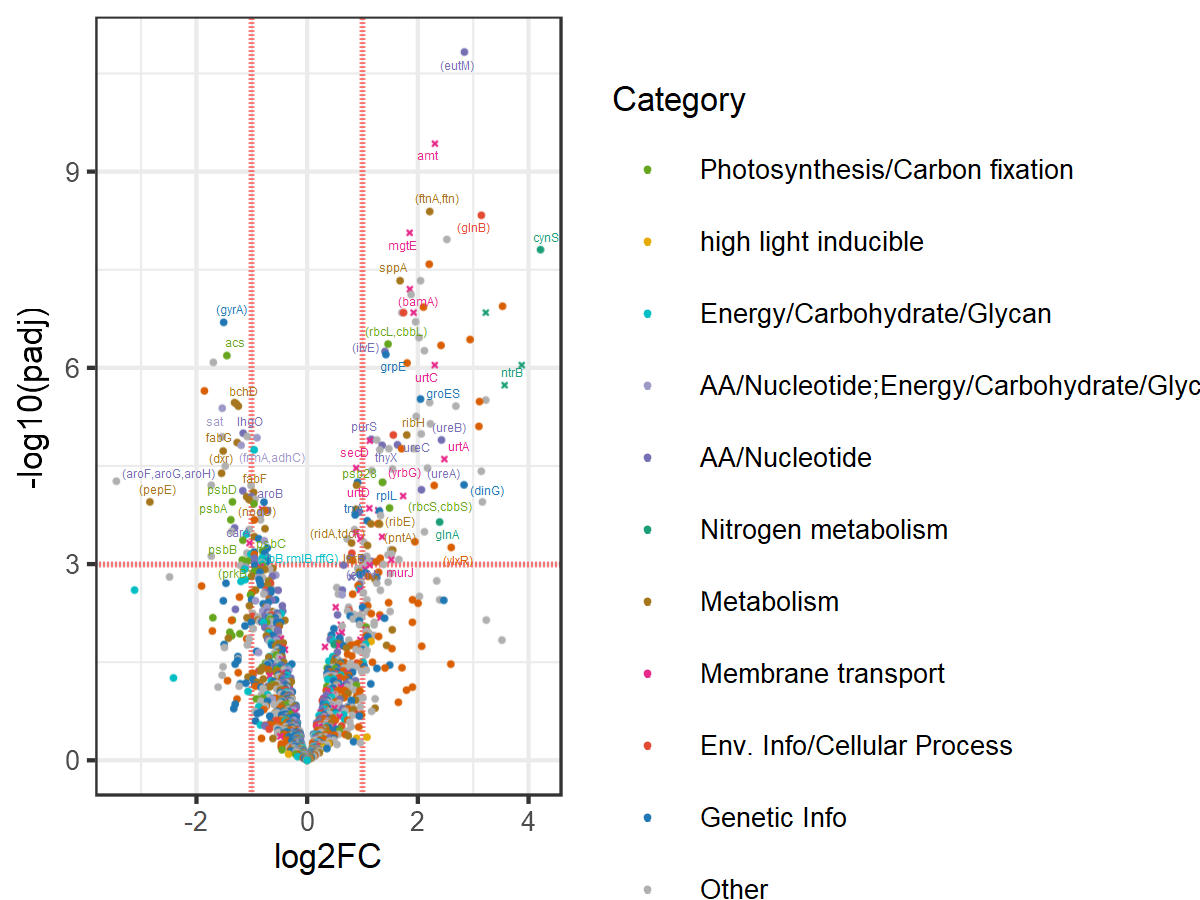

In [55]:
library(ggrepel)
assay = 'Proteome'

df_labels = df_all %>%
  filter(Assay == assay, abs(logFC) > 1, log.padj > 3, !is.na(gene), gene != '')

# Use ggplot2 allows more flexibility in plotting
df_all %>% filter(Assay == assay) %>%
ggplot(aes(x = logFC, y =log.padj, color=Category, fill=Category, shape=Membrane.transport 
          )) + 
    geom_vline(xintercept = c(-1,1), colour = "red", linetype="dotted" ) + # Add fold change cutoffs
    geom_hline(yintercept = 3, colour = "red", linetype="dotted" ) + # Add significance cutoffs
    ggrastr::geom_point_rast(size=0.3, stroke=0.3 )+
    theme_bw(base_size = 8) + # change theme
    #theme_bw() + # change theme
    xlab(expression("log2FC")) + # x-axis label
    ylab(expression(" -log10(padj)")) + # y-axis label
    #geom_vline(xintercept = 0, colour = "black") + # Add 0 lines
    scale_colour_manual(values = category.cols)+
    scale_fill_manual(values = category.cols)+
    scale_shape_manual(values = c(21,4)) +
    geom_text_repel(data=df_labels,
                   aes( logFC, log.padj ,label=gene), max.overlaps = Inf, size=1,
                   box.padding=0.05, segment.size=0.1
                   )  #+ # add gene label
    #facet_wrap(~contrast, ncol=2)

In [56]:
ggsave('figures/MED4_longterm_DE_Proteome.svg', height = 2.5, width = 4)

Warning message:
"Removed 8 rows containing missing values (`geom_point()`)."


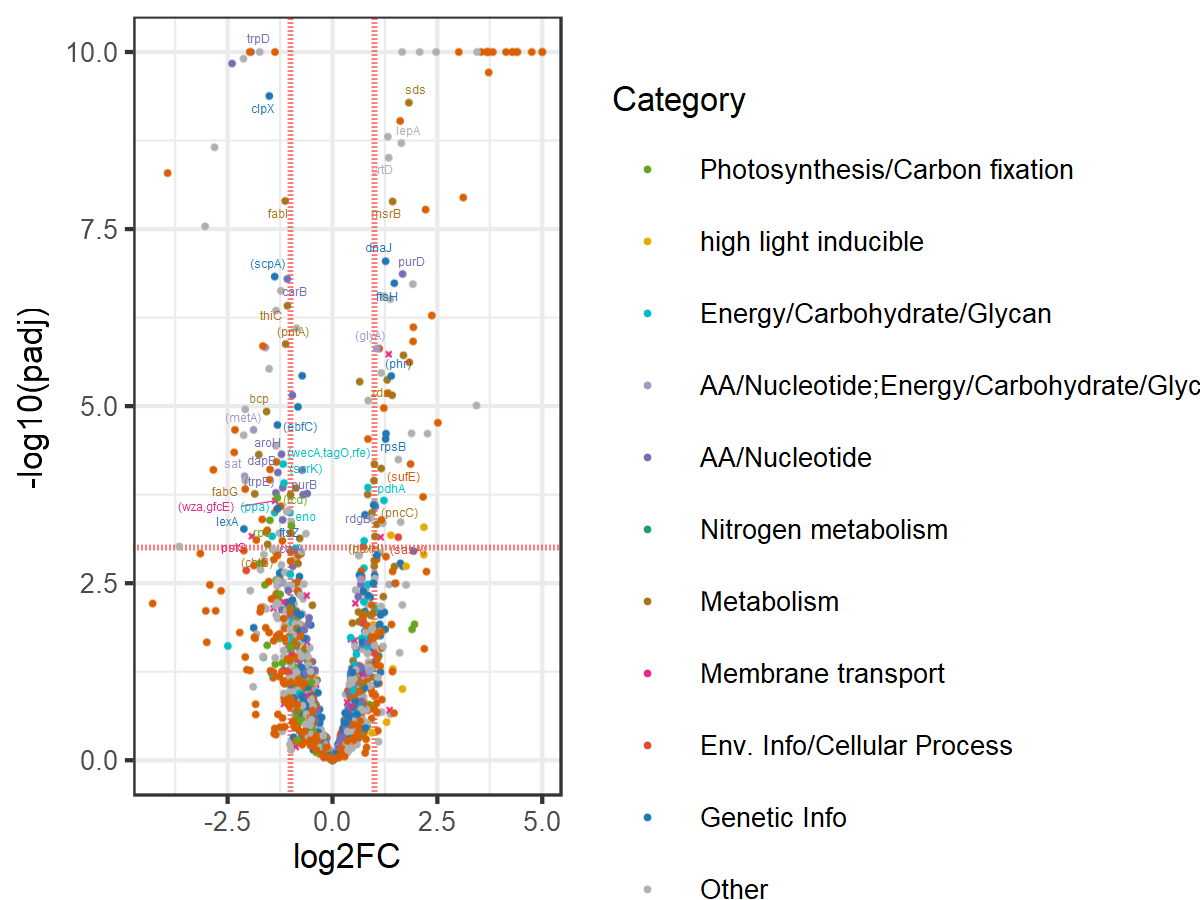

In [57]:
library(ggrepel)
assay = 'RNA'


ymax <- 10
df_all$capped.log.padj <- pmin(df_all$log.padj, ymax)
xmax <- 5
df_all$capped.logFC <- pmin(df_all$logFC, xmax)


df_labels = df_all %>%
  filter(Assay == assay, abs(logFC) > 1, log.padj > 3, !is.na(gene), gene != '')

# Use ggplot2 allows more flexibility in plotting
df_all %>% filter(Assay == assay) %>%
ggplot(aes(x = capped.logFC, y =capped.log.padj, color=Category, fill=Category, shape=Membrane.transport 
          )) + 
    geom_vline(xintercept = c(-1,1), colour = "red", linetype="dotted" ) + # Add fold change cutoffs
    geom_hline(yintercept = 3, colour = "red", linetype="dotted" ) + # Add significance cutoffs
    ggrastr::geom_point_rast(size=0.3, stroke=0.3 )+
    theme_bw(base_size = 8) + # change theme
    #theme_bw() + # change theme
    xlab(expression("log2FC")) + # x-axis label
    ylab(expression(" -log10(padj)")) + # y-axis label
    #geom_vline(xintercept = 0, colour = "black") + # Add 0 lines
    scale_colour_manual(values = category.cols)+
    scale_fill_manual(values = category.cols)+
    scale_shape_manual(values = c(21,4)) +
    geom_text_repel(data=df_labels,
                    aes( capped.logFC, capped.log.padj ,label=gene), max.overlaps = Inf, size=1,
                   box.padding=0.05, segment.size=0.1
                   )  + # add gene label
    guides(fill = guide_legend(override.aes = aes(label = "")))
    #facet_wrap(~contrast, ncol=2)

In [58]:
ggsave('figures/MED4_longterm_DE_RNA.svg', height = 2.5, width = 4)


Warning message:
"Removed 8 rows containing missing values (`geom_point()`)."


In [ ]:
df_all$kegg_gene

In [ ]:
help(ggsave)